# Synthetic data generation script for BY-COVID WP5 baseline use case
Data model specification is available at https://docs.google.com/spreadsheets/d/17561rLcEC1SeV94JUXHbcFAef2EmrsOQCB_6q0MjIM0/edit#gid=0

> **_NOTE 1:_** Please, be aware that all main parameters has been stablished based on known COVID case distribution and COVID vaccine coverage for [Aragon, Spain](https://transparencia.aragon.es/COVID19) 

> **_NOTE 2:_** Each variable simulated is accompained by figures checking their distribution


In [1]:

import matplotlib.pyplot as plt
import numpy as np
from faker import Faker
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
from datetime import date
from scipy.interpolate import InterpolatedUnivariateSpline

fake = Faker()

In [2]:
# General population information

pop_total = 1000000 # total population to be simulated
perc_vaccinated = 0.9 # percentage of population fully vaccinated (vaccination schedule completed)
pop_vaccinated = int(pop_total * perc_vaccinated) # total vaccinated population
pop_novaccinated = pop_total-pop_vaccinated # total unvaccinated population

#Modified:  Percentage of population with COVID-19 (Sciensano) = 0.37
perc_pop_with_covid = 0.37 # acummulated percentage of the population with covid during the period of study
#Modified:  Percentage of population with reinfection of COVID-19 (Sciensano) = 0.026
previous_infection_perc = 0.026 # accumulated percentage of the population with a reinfection of covid

pop_with_covid = int(perc_pop_with_covid * pop_total)
#Modified:  Percentage of population that died = 0.01210076
perc_exitus = 0.025363077  # accumulated percentage of deaths (due to all causes) in confirmed cases 
# It might be the case that you want to input the accummulated percentage of deaths in general population within the period instead
pop_exitus  = int(pop_with_covid * perc_exitus) # deceased population

#Modified: Percentage of cases with reinfection of COVID-19 = 0.070
perc_previous = 0.070 # accumulated percentage of the covid cases with a reinfection of covid
pop_with_previous = int(perc_previous*pop_with_covid) # Population with a previous confirmed case of covid


# Relevant dates
covid_starting_date = datetime.strptime('2020-02-28', '%Y-%m-%d')
vaccination_starting_date = datetime.strptime('2020-12-28' , '%Y-%m-%d')
end_date = datetime.strptime('2022-05-24', '%Y-%m-%d')



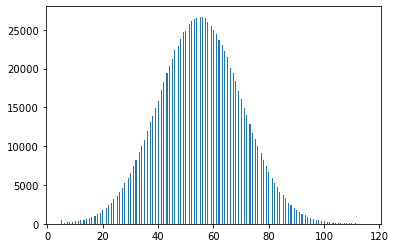

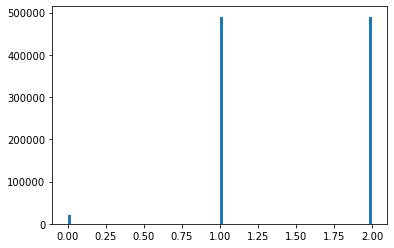

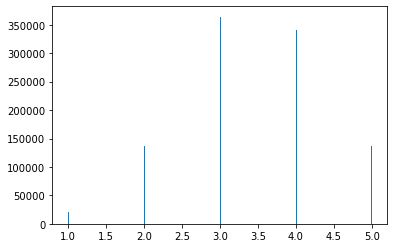

In [3]:
# age_nm
# Limits age_nm >= 5 | age_nm <= 115
# Behave: normal distribution

mu = 55
sigma = 15
age_nm = np.random.normal(mu, sigma, pop_total)
age_nm = [5 if x<5 else round(x) for x in age_nm] #correct out-of-limit values
age_nm = [115 if x>115 else round(x) for x in age_nm] #correct out-of-limit values
plt.hist(age_nm, bins='auto')
plt.show()


# sex_cd
# Options: 0 (not known), 1 (male), 2 (female), 9 (not applicable)
# Behave: prob(0) = 0.02, prob(1) = 0.49, prob(2) = 0.49, prob(9) = 0
sex_cd = np.random.choice(np.arange(0, 4),pop_total, p=[0.02,0.49,0.49,0])
plt.hist(sex_cd, bins='auto')
plt.show()


# socecon_lvl_cd
# Socioeconomic categories are based (in this case) on income quintiles
# Limits socecon_lvl_cd >= 1 | socecon_lvl_cd <= 5
# Behave: normal distribution
socecon_lvl_cd = []  
mu = 4
sigma = 1
    
socecon_lvl_cd = np.random.normal(mu, sigma, pop_total)
socecon_lvl_cd = [2 if x<1 else x for x in socecon_lvl_cd]
socecon_lvl_cd = [3 if x>6 else x for x in socecon_lvl_cd]
socecon_lvl_cd = [int(x) for x in socecon_lvl_cd]
plt.hist(socecon_lvl_cd, bins='auto')
plt.show()


# residence_area_cd
# NUTS level 3 values for Huesca, Teruel and Zaragoza (731 , 732, 733) with probabilities 
residence_area_cd = np.random.choice([731 , 732, 733,None],pop_total, p=[0.14, 0.14,0.70,0.02])


# country_cd
# Spain (ESP)
country_cd = np.random.choice(["ESP",None],pop_total, p=[0.97,0.03])
# ESP


# foreign_bl
# Options: TRUE, FALSE
# prob(TRUE) = 0.15, prob(FALSE) = 0.85
foreign_bl = np.random.choice([False,True],pop_total, p=[0.85, 0.15])


# essential_worker_bl
# Options: TRUE, FALSE
# prob(TRUE) = 0.03, prob(FALSE) = 0.97
essential_worker_bl = np.random.choice([False,True],pop_total, p=[0.97, 0.03])


# institutionalized_bl
# Options: TRUE, FALSE
# prob(TRUE) = 0.03, prob(FALSE) = 0.97
institutionalized_bl = np.random.choice([False,True],pop_total, p=[0.97, 0.03])


# Be careful! Note that a record may be assigned with a value that does not make sense,
# e.g. essential worker with an age of 6 years. 
# Clean up these mismatches at a later time.




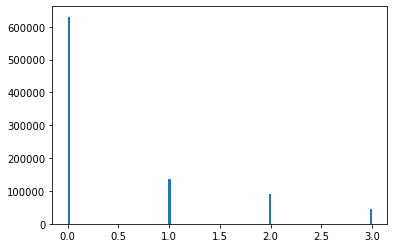

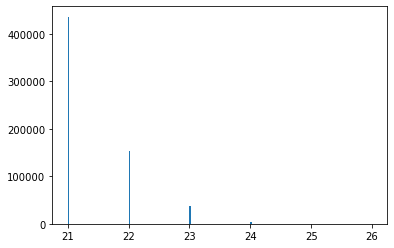

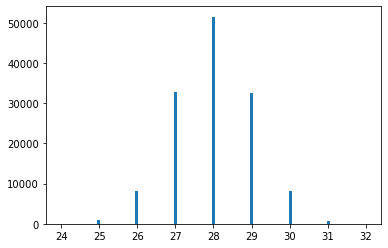

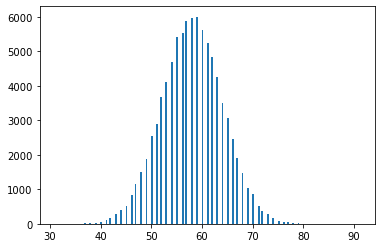

In [4]:

# Generate vaccination dates for the different vaccine brands (i.e. laboratories)
# Generate time distributions between first and second dose. !!!Note that each vaccine brand (laboratory) has its own distribution. 
# Options:  'BP' (BioNTech-Pfizer), 'MD' (Moderna), 'AZ' (Astrazeneca), 'JJ' (Johnson-Johnson), 'NV' (Novavax) (or empty)

from collections import Counter

# Distribution of laboratories, percentage of the population vaccinated by each laboratory
# prob('BP' (BioNTech-Pfizer)) = 0.70, 
# prob('MD' (Moderna)) = 0.15, 
# prob('AZ' (Astrazeneca)) = 0.10, 
# prob('JJ' (Johnson-Johnson)) = 0.05,
# prob('NV' (Novavax) (or empty)) = 0

lab_distribution = np.random.choice(np.arange(0, 5),pop_vaccinated, p=[0.70, 0.15, 0.10, 0.05, 0.00])
plt.hist(lab_distribution, bins='auto')
plt.show()

# population per vaccine brand (i.e. lab)
populationPerLab = dict(Counter(lab_distribution))
populationBP = populationPerLab[0]
populationMD = populationPerLab[1]
populationAZ = populationPerLab[2]
populationJJ = populationPerLab[3]


#BioNTech - 21 days interval between first and second dose
mu=21
sigma=1
days_from_first_dosis_bp = np.random.normal(mu, sigma, populationBP)
days_from_first_dosis_bp = [round(x) for x in days_from_first_dosis_bp]
days_from_first_dosis_bp = [21 if x<21 else x for x in days_from_first_dosis_bp]
plt.hist(days_from_first_dosis_bp, bins='auto')
plt.show()

#Moderna - 28 days interval between first and second dose
mu=28
sigma=1
days_from_first_dosis_md = np.random.normal(mu, sigma, populationMD)
days_from_first_dosis_md = [round(x) for x in days_from_first_dosis_md]
days_from_first_dosis_md = [21 if x<21 else x for x in days_from_first_dosis_md]
plt.hist(days_from_first_dosis_md, bins='auto')
plt.show()

#Astrazeneca 28 to 84 days interval between first and second dose
mu=58
sigma=6
days_from_first_dosis_az = np.random.normal(mu, sigma, populationAZ)
days_from_first_dosis_az = [round(x) for x in days_from_first_dosis_az]
days_from_first_dosis_az = [21 if x<21 else x for x in days_from_first_dosis_az]
plt.hist(days_from_first_dosis_az, bins='auto')
plt.show()

# JJ Single dose
# No time interval is necessary between first and second doses.


#shuffle values
np.random.shuffle(days_from_first_dosis_bp)
np.random.shuffle(days_from_first_dosis_md)
np.random.shuffle(days_from_first_dosis_az)

# In what period since the vaccination started is it likely that you will be vaccinated?
# This distribution is necessary to move the first and second doses to the appropriate period
period_bp = np.random.binomial(12, 0.35, size=populationBP)
period_md = np.random.binomial(12, 0.35, size=populationMD)
period_az = np.random.binomial(12, 0.35, size=populationAZ)
period_jj = np.random.binomial(12, 0.35, size=populationJJ)



In [5]:
# Generate dates of first and second doses in real periods and create the dataset with fully vaccinated people
# Methodology:
# - Generate a random date in a period greater than the study period (1)
# - Generate the date of the first dose taking into account the days between the first and second dose calculated in the previous cell (2)
# - Generate real date from the beginning of vaccination, in the period where you have to be vaccinated (3)
# - Calculate the number of months between the fictitious dates and the real month where you are due for vaccination (4)
# - Move fictitious dates of the first and second dose to the real period (5)
# - Add person to dataset with fictitious index, laboratory, first dose dt , second dose dt and number of doses (6)

#'BP' (BioNTech-Pfizer)
fake_dates = [fake.date_between_dates(date_start=datetime.strptime('2024-01-01', '%Y-%m-%d'), 
                                      date_end=datetime.strptime('2024-12-31', '%Y-%m-%d')) for x in range(0,populationBP)] # (1)
bp_population = []
for i in range(0,len(fake_dates)):
    date_2_dosis = fake_dates[i] # (1)
    days_between = days_from_first_dosis_bp[i] # (2)
    date_1_dosis = date_2_dosis - timedelta(days=days_between) # (2)
    real_period = period_bp[i] # (3)
    ref_date = vaccination_starting_date  + relativedelta(months=real_period) # (3)
    num_months = (date_1_dosis.year - ref_date.year) * 12 + (date_1_dosis.month - ref_date.month) # (4)
    date_1_dosis = date_1_dosis - relativedelta(months=num_months) # (5)
    date_2_dosis = date_2_dosis - relativedelta(months=num_months) # (5)
    bp_population.append([i,'BP',date_1_dosis,date_2_dosis,2]) # (6)

#'MD' (Moderna)
fake_dates = [fake.date_between_dates(date_start=datetime.strptime('2024-01-01', '%Y-%m-%d'), 
                                      date_end=datetime.strptime('2024-12-31', '%Y-%m-%d')) for x in range(0,populationMD)]
md_population = []
for i in range(0,len(fake_dates)):
    date_2_dosis = fake_dates[i] 
    days_between = days_from_first_dosis_md[i]
    date_1_dosis = date_2_dosis - timedelta(days=days_between)
    real_period = period_md[i]
    ref_date = vaccination_starting_date  + relativedelta(months=real_period)
    num_months = (date_1_dosis.year - ref_date.year) * 12 + (date_1_dosis.month - ref_date.month)
    date_1_dosis = date_1_dosis - relativedelta(months=num_months)
    date_2_dosis = date_2_dosis - relativedelta(months=num_months)
    md_population.append([i,'MD',date_1_dosis,date_2_dosis,2])

#'AZ' (Astrazeneca)  
fake_dates = [fake.date_between_dates(date_start=datetime.strptime('2024-01-01', '%Y-%m-%d'), 
                                      date_end=datetime.strptime('2024-12-31', '%Y-%m-%d')) for x in range(0,populationAZ)]
az_population = []
for i in range(0,len(fake_dates)):
    date_2_dosis = fake_dates[i]
    days_between = days_from_first_dosis_az[i]
    date_1_dosis = date_2_dosis - timedelta(days=days_between)
    real_period = period_az[i]
    ref_date = vaccination_starting_date  + relativedelta(months=real_period)
    num_months = (date_1_dosis.year - ref_date.year) * 12 + (date_1_dosis.month - ref_date.month)
    date_1_dosis = date_1_dosis - relativedelta(months=num_months)
    date_2_dosis = date_2_dosis - relativedelta(months=num_months)
    az_population.append([i,'AZ',date_1_dosis,date_2_dosis,2]) 


# 'JJ' (Johnson-Johnson)
# In this case it is only necessary to transfer the first dose because it does not have a second dose
fake_dates = [fake.date_between_dates(date_start=datetime.strptime('2024-01-01', '%Y-%m-%d'),
                                      date_end=datetime.strptime('2024-12-31', '%Y-%m-%d')) for x in range(0,populationJJ)]
jj_population = []
for i in range(0,len(fake_dates)):
    date_2_dosis = fake_dates[i]
    real_period = period_jj[i]
    ref_date = vaccination_starting_date  + relativedelta(months=real_period)
    num_months = (date_1_dosis.year - ref_date.year) * 12 + (date_1_dosis.month - ref_date.month)
    date_1_dosis = date_1_dosis - relativedelta(months=num_months)
    jj_population.append([i,'JJ',date_1_dosis,None,1]) 



In [6]:

# Assign third dose
# Probability of having third dose =0.6
third_dosis_bl_bp = np.random.choice(
    [False, True], populationBP, p=[0.40, 0.60])
third_dosis_bl_md = np.random.choice(
    [False, True], populationMD, p=[0.40, 0.60])
third_dosis_bl_az = np.random.choice(
    [False, True], populationAZ, p=[0.40, 0.60])
third_dosis_bl_jj = np.random.choice(
    [False, True], populationJJ, p=[0.40, 0.60])

# Obtain records with a future third dose
bp_population_with_3 = [bp_population[index] for index,
                        value in enumerate(third_dosis_bl_bp) if value == True]
md_population_with_3 = [md_population[index] for index,
                        value in enumerate(third_dosis_bl_md) if value == True]
az_population_with_3 = [az_population[index] for index,
                        value in enumerate(third_dosis_bl_az) if value == True]
jj_population_with_3 = [jj_population[index] for index,
                        value in enumerate(third_dosis_bl_jj) if value == True]


# Laboratories for third dose 'BP' (BioNTech-Pfizer) and 'MD' (Moderna) with probabilities 0.9 and 0.1 respectively (1)
# Time between the second and third doses, is set at random between 150 and 210 days (2)
# Number of doses, is set at random between 3 and 6 (3)
# Generate Dataframe from the data calculated in the previous section (4)
data = []
for p in bp_population_with_3:
    prob_lab = np.random.choice(np.arange(0, 2), 1, p=[0.90, 0.10])  # (1)
    dose_3_brand_cd = 'BP' if prob_lab == 0 else 'MD'
    data.append({'person_id': p[0],
                 'dose_1_brand_cd': p[1], 'dose_1_dt': p[2], 'dose_2_brand_cd': p[1],
                 'dose_2_dt': p[3], 'dose_3_brand_cd': dose_3_brand_cd, 'dose_3_dt': p[3]+timedelta(days=np.random.randint(150, 210)), # (2)
                'fully_vaccinated_dt': p[3], 'fully_vaccinated_bl': True, 'doses_nm': np.random.randint(3, 6)}) # (3) (4)

for p in md_population_with_3:
    prob_lab = np.random.choice(np.arange(0, 2), 1, p=[0.90, 0.10])
    dose_3_brand_cd = 'BP' if prob_lab == 0 else 'MD'
    data.append({'person_id': p[0], 'dose_1_brand_cd': p[1], 'dose_1_dt': p[2], 'dose_2_brand_cd': p[1], 'dose_2_dt': p[3], 'dose_3_brand_cd': dose_3_brand_cd, 'dose_3_dt': p[3]+timedelta(days=np.random.randint(150, 210)),
                'fully_vaccinated_dt': p[3], 'fully_vaccinated_bl': True, 'doses_nm': np.random.randint(3, 6)})

for p in az_population_with_3:
    prob_lab = np.random.choice(np.arange(0, 2), 1, p=[0.90, 0.10])
    dose_3_brand_cd = 'BP' if prob_lab == 0 else 'MD'
    data.append({'person_id': p[0], 'dose_1_brand_cd': p[1], 'dose_1_dt': p[2], 'dose_2_brand_cd': p[1],
                 'dose_2_dt': p[3], 'dose_3_brand_cd': dose_3_brand_cd, 'dose_3_dt': p[3]+timedelta(days=np.random.randint(150, 210)),
                'fully_vaccinated_dt': p[3], 'fully_vaccinated_bl': True, 'doses_nm': np.random.randint(3, 6)})

for p in jj_population_with_3:
    prob_lab = np.random.choice(np.arange(0, 2), 1, p=[0.90, 0.10])
    dose_3_brand_cd = 'BP' if prob_lab == 0 else 'MD'
    data.append({'person_id': p[0], 'dose_1_brand_cd': p[1], 'dose_1_dt': p[2], 'dose_2_brand_cd': dose_3_brand_cd,
                 'dose_2_dt': p[2]+timedelta(days=np.random.randint(150, 210)),
                'fully_vaccinated_dt': p[2], 'fully_vaccinated_bl': True, 'doses_nm': np.random.randint(2, 6)})

bp_population_without_3 = [bp_population[index]
                           for index, value in enumerate(third_dosis_bl_bp) if value == 0]
md_population_without_3 = [md_population[index]
                           for index, value in enumerate(third_dosis_bl_md) if value == 0]
az_population_without_3 = [az_population[index]
                           for index, value in enumerate(third_dosis_bl_az) if value == 0]
jj_population_without_3 = [jj_population[index]
                           for index, value in enumerate(third_dosis_bl_jj) if value == 0]

for p in bp_population_without_3:
    data.append({'person_id': p[0], 'dose_1_brand_cd': p[1], 'dose_1_dt': p[2], 'dose_2_brand_cd': p[1],
                 'dose_2_dt': p[3],
                'fully_vaccinated_dt': p[3], 'fully_vaccinated_bl': True, 'doses_nm': p[4]})

for p in md_population_without_3:
    data.append({'person_id': p[0], 'dose_1_brand_cd': p[1], 'dose_1_dt': p[2], 'dose_2_brand_cd': p[1], 'dose_2_dt': p[3],
                'fully_vaccinated_dt': p[3], 'fully_vaccinated_bl': True, 'doses_nm': p[4]})

for p in az_population_without_3:
    data.append({'person_id': p[0], 'dose_1_brand_cd': p[1], 'dose_1_dt': p[2], 'dose_2_brand_cd': p[1],
                 'dose_2_dt': p[3],
                'fully_vaccinated_dt': p[3], 'fully_vaccinated_bl': True, 'doses_nm': p[4]})

for p in jj_population_without_3:
    data.append({'person_id': p[0], 'dose_1_brand_cd': p[1], 'dose_1_dt': p[2],
                'fully_vaccinated_dt': p[2], 'fully_vaccinated_bl': True, 'doses_nm': p[4]})

df_vacunas = pd.DataFrame(data)
df_vacunas['person_id'] = np.arange(len(df_vacunas))


In [7]:

# - Create the first dataset with the basic information defined at the beginning
# - Clean previously mentioned missmatches (e.g. essential worker with an age of 6 years) (2)
# - Perform left join with the generated vaccine dataset  (3)
# - This gives us vaccinated and non-vaccinated dataset

import numpy as np
data = {'age_nm': age_nm,
        'sex_cd': sex_cd,
        'socecon_lvl_cd': socecon_lvl_cd,
        'residence_area_cd': residence_area_cd,
        'country_cd': country_cd,
        'foreign_bl': foreign_bl,
        'essential_worker_bl': essential_worker_bl,
        'institutionalized_bl': institutionalized_bl}

df1 = pd.DataFrame(data, columns=['age_nm', 'sex_cd', 'socecon_lvl_cd', 'residence_area_cd',
                   'country_cd', 'foreign_bl', 'essential_worker_bl', 'institutionalized_bl'])


df1['essential_worker_bl'] = df1.apply(lambda x: True if ((x['age_nm'] >= 18 and x['essential_worker_bl'] == True )) else False,axis=1) # (2)
df1['institutionalized_bl'] = df1.apply(lambda x: True if ((x['age_nm'] >= 18 and x['institutionalized_bl'] == True )) else False,axis=1) # (2)


# shuffle dataframe 
df1 = df1.sample(frac=1).reset_index(drop=True)

# Generate person_id to match with vaccinated
df1['person_id'] = np.arange(len(df1))   
df_total = pd.merge(df1, df_vacunas, on='person_id', how='left') # (3)


In [8]:

# Generate vaccination_schedule_cd, and concatenate: dose_1_brand_cd and dose_2_brand_cd, taking into account that 'JJ' (Johnson-Johnson) only has a single dose (1)
# Set to null the invalid concatenations because they are not vaccinated (2)
# Set fully_vaccinated_bl to False for all records with fully_vaccinated_bl with null value (3)
# If the number of doses is null, set the value to 0 (4)

df_total['vaccination_schedule_cd'] = df_total.apply(lambda x: str(x['dose_1_brand_cd'])+'-'+str(x['dose_2_brand_cd']) if x['dose_1_brand_cd'] !="JJ" else x['dose_1_brand_cd'] ,axis=1) # (1)
df_total['vaccination_schedule_cd'] = np.where((df_total['vaccination_schedule_cd']=='nan-nan'), None,df_total['vaccination_schedule_cd']) # (2)
df_total['fully_vaccinated_bl'] = np.where((df_total['fully_vaccinated_bl'].isnull()), False,True) # (3)
df_total['doses_nm'] = np.where((df_total['doses_nm'].isnull()), 0,df_total['doses_nm']) # (4)


In [9]:
# Note that there may be records with only one dose administered (NOT Johnson-Johnson)
# The population with only one dose is 5% of the unvaccinated (1)
# Generate a random date in the first year of vaccination (2)
# Assign to the record the date of first vaccination and only one dose received (3)

index_list= list(np.where(df_total["fully_vaccinated_bl"] == False)[0]) # (1)
pop_with_1_dosis = int(len(index_list)*0.05) # (1)
index_list = np.random.choice(index_list, pop_with_1_dosis)
lab_distribution = np.random.choice(['BP','MD','AZ'],pop_with_1_dosis, p=[0.10, 0.4, 0.5]) # Laboratories available with their probabilities.
i = 0
for index in index_list:
    date = fake.date_between_dates(date_start=datetime.strptime('2021-01-15', '%Y-%m-%d') , date_end=datetime.strptime('2021-10-15', '%Y-%m-%d'))  # (2)
    df_total.at[index,'dose_1_brand_cd']=lab_distribution[i] # (3)
    df_total.at[index,'dose_1_dt']=date # (3)
    df_total.at[index,'doses_nm']=1 # (3)
    i+=1

df_total['dose_1_dt'] = pd.to_datetime(df_total['dose_1_dt'])
df_total['dose_2_dt'] = pd.to_datetime(df_total['dose_2_dt'])
df_total['dose_3_dt'] = pd.to_datetime(df_total['dose_3_dt'])
df_total['fully_vaccinated_dt'] = pd.to_datetime(df_total['fully_vaccinated_dt'])


In [10]:
# variant_cd Options: 'alpha', 'beta', 'delta', 'gamma', 'omicron BA.1', 'omicron BA.2', 'lambda', 'mu'
# variant_cd data at indiviual level is not available for Aragon, Spain

df_total['variant_cd'] = None

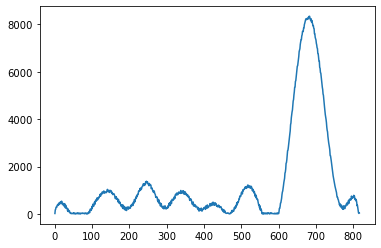

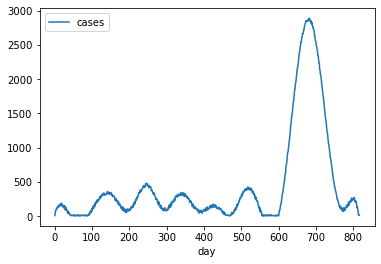

In [11]:
# In this section we try to simulate the behavior of different epidemiological waves (in this case the behavior of Aragon (Spain)).
# Reference: https://www.aragon.es/coronavirus/situacion-actual/evolucion-diaria

# Methodology:
# - Select dates and their respective values representing peaks and valleys of the distribution
#   Change the dates by the number of days between the date and the date of onset of cases (1)
# - Generate an interpolating polynomial, in this case 1-D interpolating spline of 5 degree (2)
# - For all pandemic days generate the number of cases from the interpolating polynomial (3)
# - Add noise to the resulting distribution (4)
#!!Note that the values of confirmed cases per day to generate the polynomial do not fit the number of records we are going to generate. 
# - Apply a reduction factor to the above distribution taking into account the number of records to be generated (5)
# - Generate as many dates as cases per day and day to be assigned as confirmed_case_dt 
#   (fill with null dates until the total population (not confirmed) is reached) (6)
# -  Assign to the record its confirmation date plus the type of test used for confirmation (7)
# - Add information on confirmed cases to the general dataset (8)

date = ['2020-02-29', '2020-03-29', '2020-05-29', '2020-08-08', '2020-09-22', '2020-10-30', '2020-12-16', '2021-01-27',
        '2021-03-24', '2021-04-30', '2021-06-19', '2021-07-21', '2021-10-21', '2022-01-11', '2022-04-10', '2022-05-10', '2022-05-20']  # (1)
values = [2, 266, 17, 699, 317, 1264, 247, 869,  145, 379, 90, 1016, 58, 8224, 230, 692, 200] # (1)

days = []
for f in date:
    day = datetime.strptime(f, '%Y-%m-%d') - covid_starting_date
    day = day.days
    days.append(day) # (1)

p = InterpolatedUnivariateSpline(days, values, k=5) #(2)

s = end_date - covid_starting_date # (3)
s = np.arange(s.days) # (3)
days = [x+1 for x in s] # (3)
cases = p(days)  # (3)
cases = [1 if x < 0 else x for x in cases] # (3)


cases = [x + np.random.randint(-30, 120) if x >
         40 else x + np.random.randint(5, 50) for x in cases] # (4)

plt.plot(days, cases)
df_distr_cases = pd.DataFrame({'day': days, 'cases': cases},
                         columns=['day', 'cases'])


reduction_factor = pop_with_covid / sum(df_distr_cases['cases']) # (5)
df_distr_cases['cases'] = df_distr_cases.apply(
    lambda x: int(reduction_factor*x['cases']), axis=1)
df_distr_cases.plot.line(x='day', y='cases')  # (5)


list_dates = np.ndarray(0)
for index, row in df_distr_cases.iterrows():
    date_confirmed = (covid_starting_date + timedelta(days=int(row['day'])))
    if date_confirmed >= end_date:
        date_confirmed = end_date
        date_confirmed - timedelta(days=1)
    partial_list = np.full(int(row['cases']), date_confirmed)
    list_dates = np.concatenate((list_dates, partial_list), axis=None) # (6)


list_dates = np.concatenate((list_dates, np.full(
    pop_total - len(list_dates), pd.NaT)), axis=None) # (6)
np.random.shuffle(list_dates) # (6)


data = {'confirmed_case_dt': list_dates}


df_confirmed = pd.DataFrame(data, columns=['confirmed_case_dt']) # (7)
lista_test = np.random.choice(['PCR', 'AG', 'other', None], len(
    df_confirmed), p=[0.60, 0.35, 0.04, 0.01])
np.random.shuffle(lista_test)

df_confirmed['person_id'] = np.arange(len(df_confirmed)) # (7)
df_confirmed['confirmed_case_bl'] = np.where(
    (df_confirmed['confirmed_case_dt'].isnull()), False, True) # (7)

df_confirmed['test_type_cd'] = None # (7)

index_list = list(np.where(df_confirmed["confirmed_case_bl"] == True)[0]) # (7)
i = 0
for index in index_list:
    df_confirmed.at[index, 'test_type_cd'] = lista_test[i] # (7)
    i += 1


df_total = pd.merge(df_total, df_confirmed, on='person_id', how='left') # (8)

In [12]:
# Generate previous infections
# Assign a date between 90 and 280 days prior to the date of case confirmation

df_total['previous_infection_dt'] = pd.NaT
df_total['previous_infection_bl'] = False

index_list= list(np.where(df_total["confirmed_case_dt"] >= '2021-11-11')[0])
index_list = np.random.choice(index_list, pop_with_previous)

for index in index_list:
    last_confirmed = df_total.iloc[index]['confirmed_case_dt']
    days_ = np.random.randint(90,280)
    previous_infection_dt = last_confirmed - timedelta(days=days_)
    df_total.at[index,'previous_infection_dt']=previous_infection_dt
    df_total.at[index,'previous_infection_bl']=True



In [13]:
# Generate comorbidities with a 10% flat prevalence in the total population (1)
# Please, note that nonsensical combinations may occur. Profile comorbidities in a meaningful way (2)
# Please, note that changes in comorbidities profiling might change the expected distributions generated thus changing the overall percentages

# Modified:
# Diabetes - Probability distribution: prob(TRUE) = 0.05, prob(FALSE) = 0.95
# Heart failure - Probability distribution: prob(TRUE) = 0.02, prob(FALSE) = 0.98
# COPD - Probability distribution: prob(TRUE) = 0.05, prob(FALSE) = 0.95
# Solid tumor without metastasis - Probability distribution: prob(TRUE) = 0.01, prob(FALSE) = 0.99
# Hypertension - Probability distribution: prob(TRUE) = 0.14, prob(FALSE) = 0.86
# Blood cancer - Probability distribution: prob(TRUE) = 0.01, prob(FALSE) = 0.99
# Immunosuppression - Probability distribution: prob(TRUE) = 0.01,prob(FALSE) = 0.99

data = {'diabetes_bl': np.random.choice([True,False],pop_total, p=[0.05, 0.95]),
       'obesity_bl':np.random.choice([True,False],pop_total, p=[0.10, 0.90]),
       'heart_failure_bl':np.random.choice([True,False],pop_total, p=[0.02, 0.98]),
       'copd_bl':np.random.choice([True,False],pop_total, p=[0.05, 0.95]),
       'solid_tumor_without_metastasis_bl':np.random.choice([True,False],pop_total, p=[0.01, 0.99]),
       'chronic_kidney_disease_bl':np.random.choice([True,False],pop_total, p=[0.10, 0.90]),
       'sickle_cell_disease_bl':np.random.choice([True,False],pop_total, p=[0.10, 0.90]),
       'hypertension_bl':np.random.choice([True,False],pop_total, p=[0.14, 0.86]),
       'blood_cancer_bl':np.random.choice([True,False],pop_total, p=[0.01, 0.99]),
       'transplanted_bl':np.random.choice([True,False],pop_total, p=[0.10, 0.90]),
       'hiv_infection_bl':np.random.choice([True,False],pop_total, p=[0.10, 0.90]),
       'immunosuppression_bl':np.random.choice([True,False],pop_total, p=[0.01, 0.99]),
       'primary_immunodeficiency_bl':np.random.choice([True,False],pop_total, p=[0.10, 0.90]),
       'pregnancy_bl':np.random.choice([True,False],pop_total, p=[0.10, 0.90])}



df1=pd.DataFrame(data, columns=['diabetes_bl','obesity_bl','heart_failure_bl','copd_bl','solid_tumor_without_metastasis_bl',
                                'chronic_kidney_disease_bl','sickle_cell_disease_bl','hypertension_bl','blood_cancer_bl','transplanted_bl',
                                'hiv_infection_bl','immunosuppression_bl','primary_immunodeficiency_bl','pregnancy_bl'])
df1['person_id'] = np.arange(len(df1))

df_total = pd.merge(df_total,df1,on='person_id',how='left')





In [14]:
# Profiling comorbidities
# - Assign false to those records that pregnancy_bl is true but do not meet age and gender criteria (1)
# - Assign false to records where they do not satisfy the age criteria (2)
# Please, note that comorbidities profiles could be expanded to fit more complex scenarios

df_total['pregnancy_bl'] = df_total.apply(lambda x: True if ((x['age_nm'] >= 15 and x['age_nm']<=45 
                                                              and x['sex_cd']==2 and x['pregnancy_bl'] == True )) else False,axis=1) # (1)

df_total['heart_failure_bl'] = df_total.apply(lambda x: True if (x['age_nm'] > 40 and x['heart_failure_bl'] == True ) else False,axis=1) # (2)
df_total['copd_bl'] = df_total.apply(lambda x: True if (x['age_nm'] > 40 and x['copd_bl'] == True ) else False,axis=1) # (2)
df_total['chronic_kidney_disease_bl'] = df_total.apply(lambda x: True if (x['age_nm'] > 40 and x['chronic_kidney_disease_bl'] == True ) else False,axis=1) # (2)
df_total['hypertension_bl'] = df_total.apply(lambda x: True if (x['age_nm'] > 40 and x['hypertension_bl'] == True ) else False,axis=1) # (2)
df_total['hiv_infection_bl'] = df_total.apply(lambda x: True if (x['age_nm'] > 40 and x['hiv_infection_bl'] == True ) else False,axis=1) # (2)

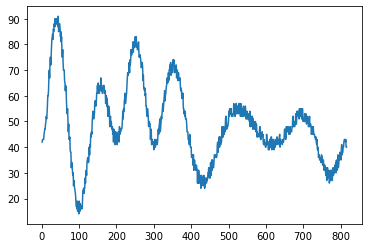

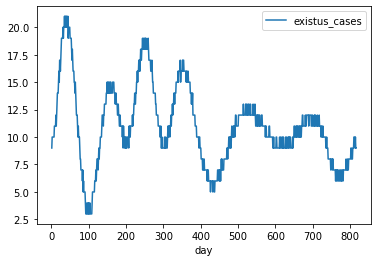

In [15]:

# In this section we try to simulate the observed daily mortality behavior for our study period (in this case the behavior of Aragon (Spain))
# Reference: https://momo.isciii.es/panel_momo/ (Aragon)

# Methodology:
# - Select dates and their respective values representing peaks and valleys of the distribution
#   Change the dates by the number of days between the date and the date of onset of cases (1)
# - Generate an interpolating polynomial, in this case 1-D interpolating spline of 5 degree (2)
# - For all pandemic days generate the number of deaths from the interpolating polynomial (3)
# - Add noise to the resulting distribution (4)
#!!Note that the values of exitus cases per day to generate the polynomial do not fit the number of records we are going to generate.
#   Apply a reduction factor to the above distribution taking into account the number of records to be generated (5)
# - Generate as many dates as cases per day and day to be assigned as exitus_dt (6)
# - Assign to the record its exitus date plus exitus_bl (7)
# - Delete dates of the first 10 days, to accumulate population susceptible to death (8) 
# - Delete dates after date of death (assigned previously) (9)
# - Add the information of the exitus cases to the general dataset (10)

date = ['2020-02-28','2020-03-01','2020-04-01','2020-05-23','2020-07-02','2020-08-07','2020-09-13', '2020-11-13','2020-12-22','2021-01-22','2021-03-30',
        '2021-06-09','2021-10-16','2022-01-09','2022-02-15','2022-03-27','2022-04-22','2022-05-12']  # (1)
values = [41,41,87,27,37,65,44,80,43,61,43,39,44,52,50,32,32,40] # (1)

days = []
for f in date:
    day = datetime.strptime(f, '%Y-%m-%d') - covid_starting_date
    day = day.days
    days.append(day) # (1)

p = InterpolatedUnivariateSpline(days, values, k=5) # (2)

s = end_date - covid_starting_date # (3)
s = np.arange(s.days) # (3)
days = [x+1 for x in s] # (3)
existus_cases = p(days)  # (3)
existus_cases = [np.random.randint(20,23) if x < 10 else int(x) for x in existus_cases] # (3)

existus_cases = [x + np.random.randint(-3, 3) for x in existus_cases] # (4)

plt.plot(days, existus_cases)
df_distr_cases = pd.DataFrame({'day': days, 'existus_cases': existus_cases},
                         columns=['day', 'existus_cases'])


reduction_factor = pop_exitus / sum(df_distr_cases['existus_cases']) # (5)
df_distr_cases['existus_cases'] = df_distr_cases.apply(
    lambda x: int(reduction_factor*x['existus_cases']), axis=1)



df_distr_cases.plot.line(x='day', y='existus_cases')  # (5)

list_dates = []
for index, row in df_distr_cases.iterrows():
    date_exitus = (covid_starting_date + timedelta(days=int(row['day'])))
    if date_exitus >= end_date:
        date_exitus = end_date
        date_exitus - timedelta(days=1)
    list_dates.append({'exitus_dt':date_exitus,'counts':row['existus_cases']}) # (6)

df_group_exitus = pd.DataFrame(list_dates, columns=['exitus_dt','counts']) # (6) 



df_total['exitus_bl'] = False  # (7)
df_total['exitus_dt'] = pd.NaT # (7)


n = 10 
df_group_exitus = df_group_exitus.iloc[10:,:] # (8)


for index,row in df_group_exitus.iterrows():    
    # Select susceptible population, not deceased, confirmed with date prior to death and at least one previous vaccination    
    exitus_dt_i = row.exitus_dt    
    pop1 = np.where((df_total['exitus_bl']==False) & ((df_total['confirmed_case_dt'] <= exitus_dt_i) | (df_total['dose_1_dt'].isnull())))[0]
    pop2 = np.where((df_total['exitus_bl']==False) & ((df_total['dose_1_dt'] <= exitus_dt_i) & (df_total['confirmed_case_dt'] <= exitus_dt_i)))[0]
    pop3 = np.where((df_total['exitus_bl']==False) & ((df_total['dose_1_dt'] <= exitus_dt_i) & (df_total['confirmed_case_dt'].isnull())))[0]
    pop = list(set(pop1).union(set(pop2),set(pop3)))
                    
    _sample = np.random.choice(pop,size=row.counts)
  
    for i in _sample:
        dose_2_dt = df_total.iloc[i]['dose_2_dt']
        dose_3_dt = df_total.iloc[i]['dose_3_dt']
        doses_nm = df_total.iloc[i]['doses_nm']
        if i in pop1:
            pass
        else:
            if doses_nm == 2:
                if dose_2_dt > exitus_dt_i:                    
                    df_total.at[i,'dose_2_dt']=pd.NaT              # (9)
                    df_total.at[i,'dose_3_dt']=pd.NaT              # (9)
                    df_total.at[i,'fully_vaccinated_bl']=False     # (9)
                    df_total.at[i,'fully_vaccinated_dt']=pd.NaT    # (9)
                    df_total.at[i,'vaccination_schedule_cd']=None  # (9)          
                    df_total.at[i,'doses_nm']=1                 
            elif doses_nm >= 3:  
                if dose_2_dt > exitus_dt_i:
                    df_total.at[i,'dose_2_dt']=pd.NaT              # (9)
                    df_total.at[i,'dose_3_dt']=pd.NaT              # (9)
                    df_total.at[i,'fully_vaccinated_bl']=False     # (9)
                    df_total.at[i,'fully_vaccinated_dt']=pd.NaT    # (9)
                    df_total.at[i,'vaccination_schedule_cd']=None  # (9)           
                    df_total.at[i,'doses_nm']=1                    # (9)
                else:
                    if dose_3_dt > exitus_dt_i:
                        df_total.at[i,'dose_3_dt']=pd.NaT          # (9)
                        df_total.at[i,'doses_nm']=2                # (9)
        df_total.at[i,'exitus_bl'] = True                          #(10)
        df_total.at[i,'exitus_dt'] = exitus_dt_i                   #(10)






In [16]:
# Check variable data types
print(df_total.dtypes)

age_nm                                        int64
sex_cd                                        int64
socecon_lvl_cd                                int64
residence_area_cd                            object
country_cd                                   object
foreign_bl                                     bool
essential_worker_bl                            bool
institutionalized_bl                           bool
person_id                                     int64
dose_1_brand_cd                              object
dose_1_dt                            datetime64[ns]
dose_2_brand_cd                              object
dose_2_dt                            datetime64[ns]
dose_3_brand_cd                              object
dose_3_dt                            datetime64[ns]
fully_vaccinated_dt                  datetime64[ns]
fully_vaccinated_bl                            bool
doses_nm                                    float64
vaccination_schedule_cd                      object
variant_cd  

In [17]:

# Assign a more realistic person_id (1)
# Save dataset with the same order of variables as the data model (2)

df_total['person_id'] = df_total.apply(lambda x: fake.pystr(max_chars=10) ,axis=1) # (1)
df_total = df_total[['person_id','age_nm','sex_cd','socecon_lvl_cd','residence_area_cd','country_cd','foreign_bl','essential_worker_bl','institutionalized_bl',
'dose_1_brand_cd','dose_1_dt','dose_2_brand_cd','dose_2_dt','dose_3_brand_cd','dose_3_dt','doses_nm','fully_vaccinated_dt','fully_vaccinated_bl','vaccination_schedule_cd',
'confirmed_case_dt','confirmed_case_bl','previous_infection_dt','previous_infection_bl','test_type_cd','variant_cd','diabetes_bl','obesity_bl','heart_failure_bl',
'copd_bl','solid_tumor_without_metastasis_bl','chronic_kidney_disease_bl','sickle_cell_disease_bl','hypertension_bl','blood_cancer_bl','transplanted_bl','hiv_infection_bl',
'primary_immunodeficiency_bl','immunosuppression_bl','pregnancy_bl','exitus_dt','exitus_bl']] # (2)
df_total.to_csv('vaccines_synthetic_1M.csv',index=False,sep='|') # (2)

#!!!Note: The synthetic dataset is saved as a CSV file, UTF-8 format, pipe-separated ("|")
